# High performance inferencing on BERT model using onnxruntime

In this tutorial, you'll learn how to:
- Load a pre-trained BERT model using huggingface transformers.
- Use it for answering questions given some context text.
- Visualise the raw scores to understand the output.
- Convert the model to ONNX format.
- Inference converted ONNX model using ONNX Runtime.
- Compare runtimes.

In the following sections, we are going to use the BERT model trained with Stanford Question Answering Dataset (SQuAD) dataset as an example. BERT SQuAD model is used in question answering scenarios, where the answer to every question is a segment of text or span, from the corresponding reading passage or the question might be unanswerable.

### Pre-requisites

Install the required Python packages from requirements.txt.

In [2]:
!pip install -r requirements.txt

  Using cached https://files.pythonhosted.org/packages/ab/e8/76cd2cb6784b9039affd2c659eed1b3f46baf2e6b87a10b072a20b5b0113/azureml-0.2.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/b7/9a09a0322fce2999cc5168a71dd25ab64bd57103e607c3865132e4a5f304/numpy-1.18.2-cp36-cp36m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/83/53/2a51e046fb94bb924556341d09f82f08bc5cc515cf4764ceb3feeebc763a/onnx-1.6.0-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/5e/55/a6829783dd0fdeccaa30a0a2083170d6528de9af068a254e3ec0ab4b594b/onnxconverter_common-1.6.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/68/db/ce33eae1c701547b99d778b64a9694e16efa7353ab98dd60d20402bdabda/onnxruntime-1.2.0-cp36-cp36m-macosx_10_14_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/94/77/a37c8877474f3b75dfe18f4901

    100% |████████████████████████████████| 890kB 22.4MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/60/10/68d949f03c994dbff789129107a2734db2313cace770008588dab51bc281/sentencepiece-0.1.85-cp36-cp36m-macosx_10_6_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e8/74/6e4f91745020f967d09332bb2b8b9b10090957334692eb88ea4afe91b77f/urllib3-1.25.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/89/e3/afebe61c546d18fb1709a61bee788254b40e736cff7271c7de5de2dc4128/idna-2.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/57/2b/26e37a4b034800c960a00c4e1b3d9ca5d7014e983e6e729e33ea2f36426c/certifi-2020.4.5.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e7/f9/f0b53f88060247251bf481fa6ea62cd0d25bf1b11a87888e53ce5b7c8ad2/py

    100% |████████████████████████████████| 276kB 973kB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 1.1MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 1.3MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/ea/0b/189cd3c19faf362ff2df5f301456c6cf8571ef6684644cfdfdbff293825c/cloudpickle-1.3.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3b/fa/181ef3fa575ed0a3b37b1850b2c221044b4b58a0ecea2aac9700dc0cac8d/dotnetcore2-2.1.13-py3-none-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/2a/ba/309a1baa25e120132fac540044b9c18f62b24f8757ae19e58d06b8d0fa46/azureml_dataprep_native-14.1.0-cp36-cp36m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/04/0b/4506cb2e831cea4b0214d3625430e921faaa05a7fb520458c75a2dbd2152/fusepy-3.0.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/69/79/e6afb3d8b0b4e96cefbdc690f741d7dd24547ff1f94240c997a26fa908d3/s3transfer

  Using cached https://files.pythonhosted.org/packages/0e/0c/04a353e104d2f324f8ee5f4b32012618c1c86dd79e52a433b64fceed511b/pycodestyle-2.5.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/84/f2/ed0ffb887f8138a8fe5a621b8c0bb9598bfb3989e029f6c6a85ee66628ee/pyflakes-2.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ae/e7/d9c3a176ca4b02024debf82342dab36efadfc5776f9c8db077e8f6e71821/pycparser-2.20-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/05/57/ce2e7a8fa7c0afb54a0581b14a65b56e62b5759dbc98e80627142b8a3704/oauthlib-3.1.0-py2.py3-none-any.whl
  Running setup.py install for fusepy ... done
  Running setup.py install for regex ... done
  Running setup.py install for sacremoses ... done
You are using pip version 18.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer

### Pre-trained BERT models for QuestionAnswering

In [2]:
list(BertForQuestionAnswering.pretrained_model_archive_map.keys())

['bert-base-uncased',
 'bert-large-uncased',
 'bert-base-cased',
 'bert-large-cased',
 'bert-base-multilingual-uncased',
 'bert-base-multilingual-cased',
 'bert-base-chinese',
 'bert-base-german-cased',
 'bert-large-uncased-whole-word-masking',
 'bert-large-cased-whole-word-masking',
 'bert-large-uncased-whole-word-masking-finetuned-squad',
 'bert-large-cased-whole-word-masking-finetuned-squad',
 'bert-base-cased-finetuned-mrpc',
 'bert-base-german-dbmdz-cased',
 'bert-base-german-dbmdz-uncased',
 'bert-base-japanese',
 'bert-base-japanese-whole-word-masking',
 'bert-base-japanese-char',
 'bert-base-japanese-char-whole-word-masking',
 'bert-base-finnish-cased-v1',
 'bert-base-finnish-uncased-v1',
 'bert-base-dutch-cased']

### Pick one of the pretrained models

In [3]:
bert_model = 'bert-large-uncased-whole-word-masking-finetuned-squad'
model = BertForQuestionAnswering.from_pretrained(bert_model)
tokenizer = BertTokenizer.from_pretrained(bert_model)

In [4]:
def process_input(question, answer_text):
    """
    This function accepts `question` string and `answer_text` string as parameters
    and returns `input_ids` and `segment_ids` expected by the BERT model.
    """
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0] * num_seg_a + [1] * num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)
    
    return input_ids, segment_ids


def reconstruct_answer(start_scores, end_scores, tokens):
    """
    This function takes the raw scores given by the model and
    computes the answer.
    Here, we consider the highest start score and highest end score for simplicity.
    In some cases, index of highest end score may be before index for highest start
    score resulting in an invalid span. An alternative would be to consider pairs of
    high start and end scores to calculate the answer.
    """
    # Find the tokens with the highest `start` and `end` scores.
    base = np if isinstance(start_scores, np.ndarray) else torch
    answer_start = base.argmax(start_scores)
    answer_end = base.argmax(end_scores)
    
    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        # If it's a subword token, then recombine it with the previous token.
        # Otherwise, add a space then the token.
        answer = f'{answer}{tokens[i][2:]}' if tokens[i][0:2] == '##' else f'{answer} {tokens[i]}'

    return answer


def answer_question(model, question, answer_text, fetch_scores=False):
    """
    Takes a `question` string and an `answer_text` string (which contains the
    answer), identifies the words within the `answer_text` that are part of the
    answer and returns them.
    """
    input_ids, segment_ids = process_input(question, answer_text)
    
    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(
        torch.tensor([input_ids]),
        token_type_ids=torch.tensor([segment_ids]))

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    return ((start_scores, end_scores, tokens) if fetch_scores
            else reconstruct_answer(start_scores, end_scores, tokens))

In [5]:
answer_text = "Coronavirus disease 2019 (COVID-19) is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The disease was first identified in December 2019 in Wuhan, the capital of China's Hubei province, and has since spread globally, resulting in the ongoing 2019–20 coronavirus pandemic.[7][8] Common symptoms include fever, cough and shortness of breath. Other symptoms may include fatigue, muscle pain, diarrhea, sore throat, loss of smell and abdominal pain. While the majority of cases result in mild symptoms, some progress to viral pneumonia and multi-organ failure. As of 7 April 2020, more than 1.35 million cases have been reported in more than 200 countries and territories, resulting in more than 74,800 deaths. More than 285,000 people have recovered."
answer_text

"Coronavirus disease 2019 (COVID-19) is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The disease was first identified in December 2019 in Wuhan, the capital of China's Hubei province, and has since spread globally, resulting in the ongoing 2019–20 coronavirus pandemic.[7][8] Common symptoms include fever, cough and shortness of breath. Other symptoms may include fatigue, muscle pain, diarrhea, sore throat, loss of smell and abdominal pain. While the majority of cases result in mild symptoms, some progress to viral pneumonia and multi-organ failure. As of 7 April 2020, more than 1.35 million cases have been reported in more than 200 countries and territories, resulting in more than 74,800 deaths. More than 285,000 people have recovered."

In [6]:
question = "What is COVID19?"

answer_question(model, question, answer_text)

Query has 187 tokens.



'an infectious disease caused by severe acute respiratory syndrome coronavirus 2'

In [7]:
question = "What are the symptoms of COVID19?"

answer_question(model, question, answer_text)

Query has 190 tokens.



'fever , cough and shortness of breath'

In [8]:
start_scores, end_scores, tokens = answer_question(model, question, answer_text, fetch_scores=True)

Query has 190 tokens.



### Visualise output scores

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size
plt.rcParams["figure.figsize"] = (32,8)

In [10]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

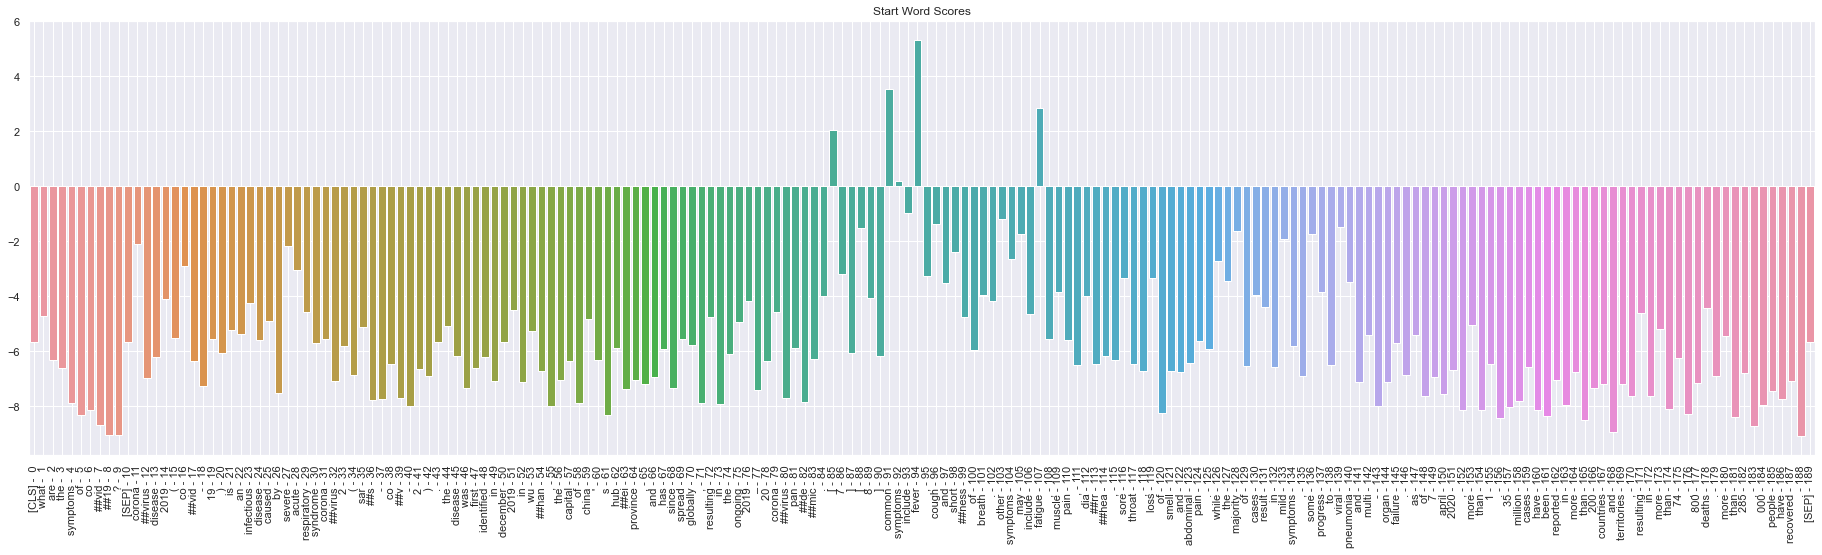

In [11]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

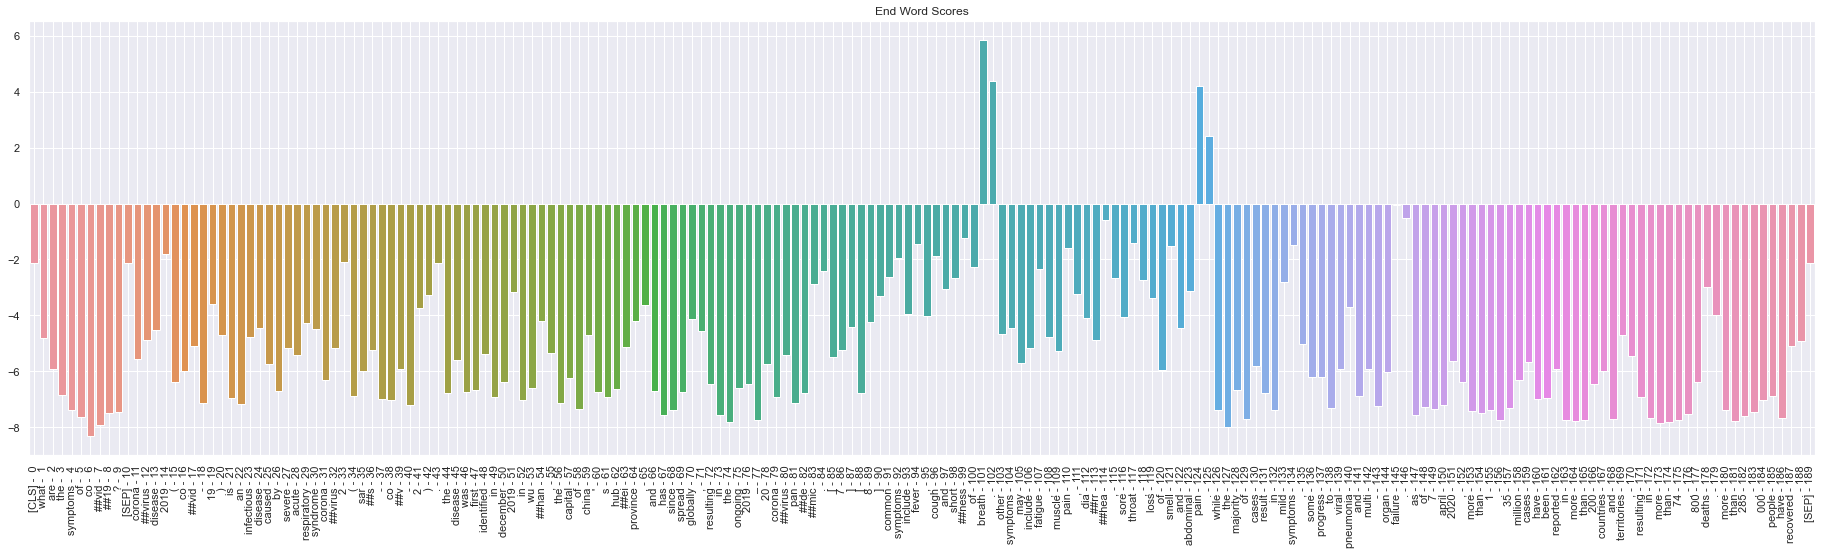

In [12]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

### Conversion to ONNX

In [13]:
import numpy as np

def convert_to_onnx(model, question, answer_text):
    input_ids, segment_ids = process_input(question, answer_text)
    # Set model to inference mode, which is required before exporting
    # the model because some operators behave differently in inference and training mode.
    model.eval()
    onnx_model_path = 'bert-model.onnx'
    with torch.no_grad():
        symbolic_names = {0: 'batch_size', 1: 'max_seq_len'}
        torch.onnx.export(
            model,                                                          # model being run
            (torch.Tensor(input_ids).reshape((1, -1)).type(torch.int64),    # model input ...
            torch.Tensor(segment_ids).reshape((1, -1)).type(torch.int64)),  # ... or a tuple for multiple inputs
            onnx_model_path,                                                # onnx model path
            input_names=['input_ids', 'segment_ids'],                       # model's input names
            output_names=['start', 'end'],                                  # model's output names
            dynamic_axes={                                                  # variable length axes
                'input_ids': symbolic_names,        
                'segment_ids' : symbolic_names,
                'start' : symbolic_names,
                'end' : symbolic_names
            }                     
        )
    print(f'Model exported as {onnx_model_path}')
    return onnx_model_path

In [14]:
onnx_model = convert_to_onnx(model, question, answer_text)

Query has 190 tokens.



/Users/prroy/Documents/MachineLearning/conferences/onnx-odsc-east/odsc_east_venv/lib/python3.6/site-packages/torch/onnx/symbolic_opset9.py:433: UserWarning: ONNX export squeeze with negative axis -1 might cause the onnx model to be incorrect. Negative axis is not supported in ONNX. Axis is converted to 2 based on input shape at export time. Passing an tensor of different rank in execution will be incorrect.
  "Passing an tensor of different rank in execution will be incorrect.")


Model exported as bert-model.onnx


### Visualise using Netron
Visualise the ONNX model using Netron: https://lutzroeder.github.io/netron/

### Model Inferencing
To inference ONNX model, we'll be using ONNX Runtime.

In [15]:
from onnxruntime import InferenceSession

ort_session = InferenceSession(onnx_model)

### Run prediction on ONNX model

In [16]:
input_ids, segment_ids = process_input(question, answer_text)
tokens = tokenizer.convert_ids_to_tokens(input_ids)

res = ort_session.run(
    None, {
        'input_ids': np.array(input_ids, dtype=np.int64).reshape((1, -1)),
        'segment_ids': np.array(segment_ids, dtype=np.int64).reshape((1, -1))
    }
)

Query has 190 tokens.



In [17]:
reconstruct_answer(res[0], res[1], tokens)

'fever , cough and shortness of breath'

### Compare runtimes

In [18]:
# Get onnx and torch model inputs in the right format
onnx_inputs = (np.array(input_ids, dtype=np.int64).reshape((1, -1)),
               np.array(segment_ids, dtype=np.int64).reshape((1, -1)))
torch_inputs = (torch.tensor([input_ids]), torch.tensor([segment_ids]))

In [19]:
%%timeit -n 10
res1 = ort_session.run(
    None, {
          'input_ids': onnx_inputs[0],
          'segment_ids': onnx_inputs[1] 
        }
)

508 ms ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%timeit -n 10
res2 = model(
        torch_inputs[0],
        token_type_ids=torch_inputs[1])

794 ms ± 52.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Connect to your AML Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. The workspace holds all your experiments, compute targets, models, datastores, etc.

You can open [ml.azure.com](https://ml.azure.com/) to access your workspace resources through a graphical user interface of Azure Machine Learning studio.

![AML workspace](./images/aml-workspace.png)

**You will be asked to login in the next step.** Use the credentials you used to sign in to Azure.

If you've already created a workspace, we can load it now. Import the Workspace class, and load your subscription information from the file config.json using the function from_config(). This looks for the JSON file in the current directory by default, but you can also specify a path parameter to point to the file using from_config(path="your/file/path"). **In a cloud notebook server, the file is automatically in the root directory.**

In [21]:
from azureml.core import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: prroy-odsc-europe
Azure region: uksouth
Resource group: prroy-rg


### Register your trained model
To keep track of our models from various runs we may be testing, we will register the model from the run to our workspace. The model_path parameter takes in the relative path on the remote VM to the model file in your outputs directory. You can then deploy this registered model as a web service through the AML SDK.

In [22]:
from azureml.core.model import Model

model_path = 'bert-model.onnx'
ml_model = Model.register(workspace = ws,
               model_path = model_path,
               model_name = "bert-model",
               tags = {"onnx": "demo"},
               description = "Question Answering using BERT")
print(ml_model.name, ml_model.id, ml_model.version, sep = '\t')

Registering model bert-model
bert-model	bert-model:2	2


### Deploying your model as a web service
Now we are ready to [deploy](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where) the model as a web service. For this notebook we will deploy this to run on an Azure Container Instance [ACI](https://azure.microsoft.com/en-us/services/container-instances/), but you can alternatively also run on your [local](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where#local) machine or with Azure Kubernetes Service [AKS](https://azure.microsoft.com/en-us/services/kubernetes-service/). 

Azure Machine Learning accomplishes this by constructing a Docker image with the scoring logic and model baked in. We will deploy our ONNX model on Azure ML using ONNX Runtime inference engine. 

**To build the correct environment, provide the following:**

* A scoring script to show how to use the model
* An environment file to show what packages need to be installed
* A configuration file to build the web service
* The model you trained before

### Write scoring file
We begin by writing a score.py file that will be invoked by the web service call.

Note that the scoring script must have two required functions, init() and run(input_data).
* The **init()** function is called once when the container is started so we load the model using the ONNX Runtime into a global session object. This function is executed only once when the Docker container is started.
* In **run(input_data)** function, the model is used to predict a value based on the input data. The input and output to run typically use JSON as serialization and de-serialization format but you are not limited to that.

In [56]:
%%writefile score.py

import os
import json
import time
import numpy as np
from onnxruntime import InferenceSession
from transformers import BertTokenizer


def init():
    global session
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_onnx = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'bert-model.onnx')
    session = InferenceSession(model_onnx)
    

def preprocess(input_data_json):
    question = json.loads(input_data_json)['question'][0]
    answer_text = json.loads(input_data_json)['answer_text'][0]
    tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
    
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0] * num_seg_a + [1] * num_seg_b
    
    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    return (np.array(input_ids, dtype=np.int64).reshape((1, -1)),
            np.array(segment_ids, dtype=np.int64).reshape((1, -1)), tokens)


def postprocess(result, tokens):
    answer_start = np.argmax(result[0])
    answer_end = np.argmax(result[1])
    
    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        answer = f'{answer}{tokens[i][2:]}' if tokens[i][0:2] == '##' else f'{answer} {tokens[i]}'

    return answer


def run(input_data_json):
    try:
        start = time.time()   # start timer
        input_ids, segment_ids, tokens = preprocess(input_data_json)
        input_name_0 = session.get_inputs()[0].name  # get the id of the first input of the model  
        input_name_1 = session.get_inputs()[1].name 
        result = session.run(None, {input_name_0: input_ids, input_name_1: segment_ids})
        end = time.time()     # stop timer
        return {"result": postprocess(result, tokens),
                "time": end - start}
    except Exception as e:
        result = str(e)
        return {"error": result}

Overwriting score.py


### Set the evironment and inference configurations
First we create a YAML file that specifies which dependencies we would like to see in our container.

In [57]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(pip_packages=["numpy", "onnxruntime", "azureml-core", "transformers", "torch"])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

Then we setup the [inference configuration](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model.inferenceconfig?view=azure-ml-py).

In [58]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(runtime= "python", 
                                   entry_script="score.py",
                                   conda_file="myenv.yml",
                                   extra_docker_file_steps = "Dockerfile")

### Deploy the model using [Azure Container Instances](https://docs.microsoft.com/en-us/azure/container-instances/container-instances-overview)
**Estimated time to complete: about 3-7 minutes**

Configure the image and deploy.

In [60]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 4, 
                                               tags = {'demo': 'BERT + onnx'}, 
                                               description = 'web service for BERT Q & A ONNX model')

The following code goes through these steps:

Build an image using:
* The scoring file (score.py)
* The environment file (myenv.yml)
* The model file
* Define ACI Deployment Configuration
* Send the image to the ACI container.
* Start up a container in ACI using the image.
* Get the web service HTTP endpoint.

In [62]:
from azureml.core.model import Model
from random import randint

aci_service_name = f'onnx-bert-{randint(0,100)}'
print("Service", aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [ml_model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

Service onnx-bert-46
Creating image
Running...........................................................................
Succeeded
Image creation operation finished for image onnx-bert-46:1, operation "Succeeded"
Running...................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In case the deployment fails, you can check the logs. Make sure to delete your aci_service before trying again.

In [63]:
if aci_service.state != 'Healthy':
    # run this command for debugging.
    print(aci_service.get_logs())
    aci_service.delete()

### Success!
If you've made it this far, you've deployed a working web service that does sports image classification using an ONNX model. You can get the URL for the webservice with the code below.

In [64]:
service_url = aci_service.scoring_uri
service_url

'http://07ae7da0-5dbc-427a-a933-67d72ba15a81.uksouth.azurecontainer.io/score'

### Test the service
To submit sample data to the running service, use the following code.

In [11]:
import requests
import json

service_url = 'http://07ae7da0-5dbc-427a-a933-67d72ba15a81.uksouth.azurecontainer.io/score'
test_sample = json.dumps({
    "question": ["What is Sherlock Holmes famous for?"],
    "answer_text": ["Sherlock Holmes is a fictional private detective created by British author Sir Arthur Conan Doyle. Referring to himself as a 'consulting detective' in the stories, Holmes is known for his proficiency with observation, deduction, forensic science, and logical reasoning that borders on the fantastic, which he employs when investigating cases for a wide variety of clients, including Scotland Yard."]
})
test_sample = bytes(test_sample, encoding = 'utf8')
headers = {'Content-Type':'application/json'}
resp = requests.post(service_url, test_sample, headers=headers)
print("prediction:", resp.text)

prediction: {"result": "his proficiency with observation , deduction , forensic science , and logical reasoning", "time": 2.6233253479003906}
